#  Week 3: Hyperparameter optimisation With Neural Networks in AWS SageMaker

This week we will focus on:

1. Clarify AWS Sagemaker and Why we might want to use it
2. How to implement hyperparmeter optimisation (HPO) on AWS SageMaker
3. How to deploy the best model from HPO. 

## Hyperparameters: 
    
There are **3** different types of hyperparameters:  
   + Categorical parameters  are defined by passing the list of possible values to **CategoricalParameter(list)**
   + Continuous parameters can take any real number value between the minimum and maximum value, defined by **ContinuousParameter(min, max)**
   + Integer parameters can take any integer value between the minimum and maximum value, defined by **IntegerParameter(min, max)**


## Data and Model:

We will use the same dataset (Fashion MNIST) and same VNN model structure generated in week 1. Our task is to find the "optimal" values for each of the following hyperparameters: *batch size, epochs, learning rate,* and *dense-layer*.


### What is AWS Sagemaker? 

- Cloud based, machine learning platform that helps users to build, train, tune and deploy machine learning applications. 
- Uses subscription pricing model (only pay for what you use)
- In built tools for data management (e.g. Amazon S3) building, training, deploying and monitoring machine learning models.
- AWS Sagemaker Stack includes: 
   1. AI Services (pre-trained models and pre-build algorithms); 
   2. ML services (IDE for ML); 
   3. ML frameworks (Tensorflow, Keras and more...) - we use a structure developed by CS/engineers
- This means there are many ways to train models in SageMaker. Today we will use a notebook instance in *script mode*. 

#### Jupyter Labs in AWS Sagemaker

- Many templates for analyses 

Before you start: Check directory structure and modify permissions

In [1]:
%%sh
ls -l

total 72
drwx------ 2 root     root     16384 May 19 03:58 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 54866 May 19 04:02 Prac3_MNIST_fashion_VNN_HPO.ipynb


Do you have a lost+found folder with root group and owner? If so, you will need to change the permissions of to lost+found to prevent future errors. Note, I am in contact with AWS Support for a better solution and will keep you all updated!

In [2]:
%%sh
sudo chown ec2-user lost+found

In [3]:
%%sh
ls -l

total 72
drwx------ 2 ec2-user root     16384 May 19 03:58 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 54866 May 19 04:02 Prac3_MNIST_fashion_VNN_HPO.ipynb


In [4]:
%%sh
sudo chgrp ec2-user lost+found

In [5]:
%%sh
ls -l 

total 72
drwx------ 2 ec2-user ec2-user 16384 May 19 03:58 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 54866 May 19 04:02 Prac3_MNIST_fashion_VNN_HPO.ipynb


Set up our environment:

In [6]:
import os
import keras
import numpy as np

# Not getting data again, as already have it stored in S3 from last week. 
# Just un-hash the following lines if you don't already have the data in S3
#from keras.datasets import fashion_mnist
#(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

Using TensorFlow backend.



4423680/4422102 [==============================] - 3s 1us/step


We create a local directory and save the training and test data seoerately

In [2]:
# Again, not saving the data again, as already have it stored in S3 from last week. 
# Just un-hash the following lines if you don't already have the data in S3

#os.makedirs("./data", exist_ok=True)
#np.savez('./data/training', image = x_train, label=y_train)
#np.savez('./data/test', image=x_val, label=y_val)    

Import SageMaker, set session and get IAM role

In [7]:
# We first need to import the necessary libraries and define some environment variables  
## Import sagemaker and retrieve IAM role, which determines your user identity and permissions

import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.39.1


Upload data to S3 bucket

In [14]:
# Upload data to S3 bucket
## If you already ran the week 2 lab and stored the data in S3 then you can skip uploading the data and 
## just enter the same keys for the data as last week. 

#SAVE DATA TO S3
#prefix = 'keras-mnist-fashion' #first define a prefix for the key (think of this like a directory or file path)

#upload a local file/directory to S3 using upload_data(). 
##inputs = path, bucket (if not specifified will use default_bucket), optional prefix for directory structure
#training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

#test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

#OR; DEFINE KEY TO EXISTING S3 - look in S3 section of AWS

training_input_path = 's3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/training/training.npz'
test_input_path = 's3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/validation/test.npz'

#CHECK PATHS
print(training_input_path)
print(test_input_path)

s3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/training/training.npz
s3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/validation/test.npz


# HPO

We want to tune: 

- Epochs
- Learning Rate
- Batch Size
- Dense-layer

Question... are these:

- Categorical parameters (defined using **CategoricalParameter(list)**)
- Continuous parameters  (defined using **ContinuousParameter(min, max)**)
- Integer parameters (defined using **IntegerParameter(min, max)**)


In [9]:
# Define parameter ranges :

from sagemaker.tuner import IntegerParameter, ContinuousParameter

# Discuss = what the following code does... 

hyperparameter_ranges = { 
    'epochs' :       IntegerParameter(5, 10), 
    'learning-rate': ContinuousParameter(0.001, 0.1, scaling_type='ReverseLogarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
    'dense-layer':   IntegerParameter(32, 1024),
}#Dictionary of parameter ranges. Can be one of three types: Continuous, Integer, or Categorical. The keys of the dictionary are the names of the hyperparameter, and the values are the appropriate parameter range class to represent the range.

print(hyperparameter_ranges)

# Can you think of anything else you might like to test/change? ........ e.g. optimiser type


{'epochs': <sagemaker.parameter.IntegerParameter object at 0x7fc9a6e89860>, 'learning-rate': <sagemaker.parameter.ContinuousParameter object at 0x7fc9a6e89358>, 'batch-size': <sagemaker.parameter.IntegerParameter object at 0x7fc9a6e89470>, 'dense-layer': <sagemaker.parameter.IntegerParameter object at 0x7fc9a6e89400>}


Need to specify the objective metric that we wish to tune. This includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. 

In [10]:
# Use this if Tensorflow 2 is used
objective_metric_name = 'validation_accuracy' #name for the metric for evaluating training jobs

objective_type = 'Maximize' #do we want to minimise or maximise the named objective metric?

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'}
    ] #A list of dictionaries that defines the metric(s) used to evaluate the training jobs (default: None). 
    # Each dictionary contains two keys: ‘Name’ for the name of the metric, and ‘Regex’ for the regular expression
    # used to extract the metric from the logs.

In [11]:
from sagemaker.tensorflow import TensorFlow

# Configure a training job using the Tensorflow estimator, the parameter ranges and the metric defined above.
# Let's run ten individual jobs, two by two.

tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn_tf2.py',  
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge',
                          framework_version='2.1.0', 
                          py_version='py3',
                          script_mode=True,
                          # Optional - see notes from Week 2 Lab
                          use_spot_instances=True,        # Use spot instance
                          max_run=3600,                   # Max training time
                          max_wait=7200)    
    
from sagemaker.tuner import HyperparameterTuner

#HyperparameterTuner() Defines interaction with Amazon SageMaker hyperparameter tuning jobs.
#Creates a HyperparameterTuner instance.

# we pass the tf_estimator to HyperparameterTuner(), and pass in the objective_metric_name, 
#objective_type and metric_definitions that we defined in the previous cell
tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name, #see cell above for definition
                            hyperparameter_ranges, #see cell above for definition
                            metric_definitions, #see cell above for definition
                            max_jobs=4,  #the maximum number of total training jobs to start - I set 4 just for illustration and time waiting
                            max_parallel_jobs=2, #Maximum number of parallel training jobs to start
                            objective_type=objective_type) #see cell above for definition

# Homework - if you don't want SageMaker to randomly chose the values for the hyperparameter, 
# but want to select the exact values - how would you do this?
    

In [15]:
#fit is used to train the model
tuner.fit({'training': training_input_path, 'validation': test_input_path})

........................................................................................................!


## Visualising the Model

Homework :) 

### 1. Cloud Watch 

- Naviagate to CW in AWS console
- Logs - Log groups = all logs from how the model was trained, and values for metrics for each epoch
- Metrics 
    - Host = CPUs 
    - TrainingJobNames = graph metrics
    
### 2. Tensorboard

- Jupyter Labs
- Click on Brain symbol
- Scroll down to folder 'Sagemaker Python SDK'
- open tensorboard_keras
- Click create copy
- Follow along with the example 


# Inspect jobs with AWS

In [16]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

#HyperparameterTuningJobAnalytics() 
#Fetch results about a hyperparameter tuning job and make them accessible for analytics

exp = HyperparameterTuningJobAnalytics( 
    sagemaker_session=sess, #Session object 
    hyperparameter_tuning_job_name=tuner.latest_tuning_job.name #name of the HyperparameterTuningJob to analyze.
)

df = exp.dataframe()
df

,batch-size,dense-layer,epochs,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,96.0,952.0,5.0,0.094524,tensorflow-training-210519-0409-004-82bda1a0,Completed,0.8590,2021-05-19 04:16:10+00:00,2021-05-19 04:17:49+00:00,99.0
1,38.0,792.0,9.0,0.049661,tensorflow-training-210519-0409-003-1dff4203,Completed,0.8613,2021-05-19 04:15:55+00:00,2021-05-19 04:17:38+00:00,103.0
2,1012.0,535.0,7.0,0.088584,tensorflow-training-210519-0409-002-3197c548,Completed,0.8608,2021-05-19 04:12:19+00:00,2021-05-19 04:13:44+00:00,85.0
3,807.0,642.0,6.0,0.023696,tensorflow-training-210519-0409-001-9168034f,Completed,0.8492,2021-05-19 04:12:08+00:00,2021-05-19 04:13:14+00:00,66.0


In [17]:
# Select the best job by highest accuracy

best_job = df.sort_values('FinalObjectiveValue', ascending=0)[:1] # pandas.df.sort_values
                                                                  # FinalObjectiveValue = Accuracy
best_job

,batch-size,dense-layer,epochs,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,38.0,792.0,9.0,0.049661,tensorflow-training-210519-0409-003-1dff4203,Completed,0.8613,2021-05-19 04:15:55+00:00,2021-05-19 04:17:38+00:00,103.0


In [18]:
# Pull out the name of the best job

best_job_name = best_job['TrainingJobName'].to_string(index=False).strip()
best_job_name

'tensorflow-training-210519-0409-003-1dff4203'

[optional] Check location of where the best model is stored.

In [19]:
# Finding where the best model is stored 

import boto3 
sm = boto3.client('sagemaker') # where the model is being stored in s3

In [20]:
# Save best model

best_job = sm.describe_training_job(TrainingJobName=best_job_name)

best_model_artefact = best_job['ModelArtifacts']['S3ModelArtifacts']
best_model_container = best_job['AlgorithmSpecification']['TrainingImage']

print(best_job_name)
print(best_model_artefact)
print(best_model_container)

tensorflow-training-210519-0409-003-1dff4203
s3://sagemaker-ap-southeast-2-580121432832/tensorflow-training-210519-0409-003-1dff4203/output/model.tar.gz
763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-training:2.1.0-cpu-py3


# Deploy the best model



In [21]:
# Don't forget to update the bucket! It must be in the same region as SageMaker
s3_capture_path = 's3//sagemaker-ap-southeast-2-580121432832/' + best_job_name + '/'

print(s3_capture_path)

s3//sagemaker-ap-southeast-2-580121432832/tensorflow-training-210519-0409-003-1dff4203/


In [22]:
endpoint_name = best_job_name + '-ep'
print(endpoint_name)


tensorflow-training-210519-0409-003-1dff4203-ep


In [23]:
# Deploy the best model 

best_model_predictor = tuner.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge', 
    endpoint_name=endpoint_name)


2021-05-19 04:17:38 Starting - Preparing the instances for training
2021-05-19 04:17:38 Downloading - Downloading input data
2021-05-19 04:17:38 Training - Training image download completed. Training in progress.
2021-05-19 04:17:38 Uploading - Uploading generated training model
2021-05-19 04:17:38 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



-------------!

### Prediction exercise


In [24]:
 %matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 500
all_labels=[]
all_predicted_labels=[]

import sys

for i in range(0,x_val.shape[0] - 1,num_samples):
    sys.stdout.write(str(i)+' ')
    indices = range(i,i+num_samples)
    images = x_val[indices]/255
    labels = y_val[indices]
    prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
    prediction = np.array(prediction)
    predicted_labels = prediction.argmax(axis=1)
    all_labels.extend(labels)
    all_predicted_labels.extend(predicted_labels)

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

### Creating confusion matrix

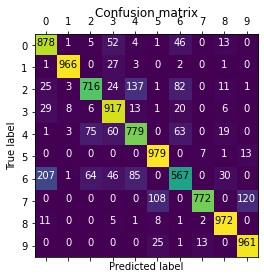

In [23]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predicted_labels)
plt.matshow(cm)
plt.title('Confusion matrix')
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
classes = range(10) # Labels are sorted 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)
plt.show()

### Delete the end point

In [25]:
best_model_predictor.delete_endpoint()